In [20]:
!pip install pyrsgis
!pip install geopandas 
!pip install rasterio

     |████████████████████████████████| 1.0 MB 12.4 MB/s 
     |████████████████████████████████| 16.7 MB 321 kB/s 
     |████████████████████████████████| 6.3 MB 29.8 MB/s 
     |████████████████████████████████| 19.3 MB 1.2 MB/s 


In [21]:
import numpy as np
import rasterio 
import geopandas 
import matplotlib.pyplot as plt
import sklearn
import os
import pandas as pd
import geopandas as gpd
import keras.backend as K
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
import tensorflow as tf

In [22]:
os.chdir('/content/drive/MyDrive/MyinGyan_corn')

In [23]:
!ls

 Corn_classified.tif		  finale_training_pts_v2.shx
 evi_data_cube.tif		  Landcover_classified.tif
 finale_training_pts_v2.cpg	 'masked corn20.tif'
 finale_training_pts_v2.dbf	  masked_corn_detected.tif
 finale_training_pts_v2.prj	  ndvi_training_datacube.tif
 finale_training_pts_v2.sbn	  training_data_cube.tif
 finale_training_pts_v2.sbx	  Training_image_modis.tif
 finale_training_pts_v2.shp	  Unsupervised_clustered_image_reproject.tif
 finale_training_pts_v2.shp.xml   Unsupervised_clustered_image.tif


In [24]:
#src=  rasterio.open('ndvi_training_datacube.tif')
src = rasterio.open('/content/drive/MyDrive/MyinGyan_corn/evi_data_cube.tif')

In [25]:
# Magic code - this piece if code simply creates an exact copy of our input dataset and saves it in memory file. 
# There should be no reason to do this but this step increases the speed of the trainnig data extraction 
# from 2 hrs without it to 10 sec with creating the copy.
img = src.read()   # load our original input file bands to a numby array stack
print(img.shape)
#profile = src.profile  # the copy the profile of the original GeoTIFF input file
#with rasterio.io.MemoryFile() as memfile:
#    with memfile.open(**profile) as dst:
#        for i in range(0, src.count):
#            dst.write(img[i], i+1)
#    dataset = memfile.open()

(34, 1960, 2335)


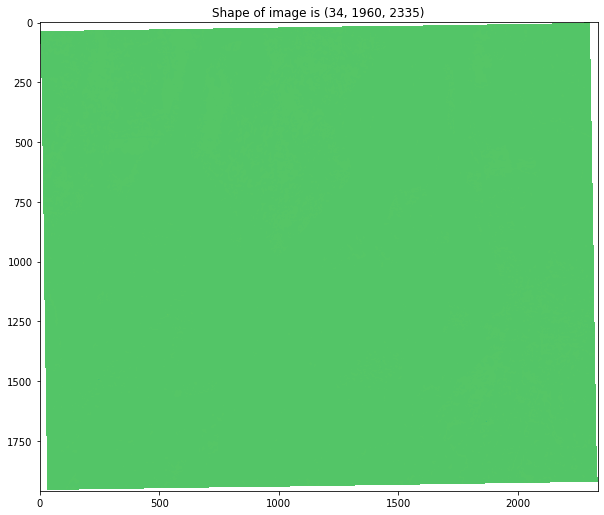

In [26]:
plt.figure(figsize=(10,10))
plt.imshow(img[1])
plt.title(label=f'Shape of image is {img.shape}');

In [27]:
bands = list(src.descriptions)
print(bands)

['EVI', 'EVI_1', 'EVI_2', 'EVI_3', 'EVI_4', 'EVI_5', 'EVI_6', 'EVI_7', 'EVI_8', 'EVI_9', 'EVI_10', 'EVI_11', 'EVI_12', 'EVI_13', 'EVI_14', 'EVI_15', 'EVI_16', 'EVI_17', 'EVI_18', 'EVI_19', 'EVI_20', 'EVI_21', 'EVI_22', 'EVI_23', 'EVI_24', 'EVI_25', 'EVI_26', 'EVI_27', 'EVI_28', 'EVI_29', 'EVI_30', 'EVI_31', 'EVI_32', 'EVI_33']


In [28]:
print(type(bands))

<class 'list'>


In [30]:
import pandas as pd
train_pts = pd.read_csv('/content/EVI training data.csv')
train_pts.head()

,ID,RASTERVALU,UTM_E,UTM_N,geometry,EVI,EVI_1,EVI_2,EVI_3,EVI_4,EVI_5,EVI_6,EVI_7,EVI_8,EVI_9,EVI_10,EVI_11,EVI_12,EVI_13,EVI_14,EVI_15,EVI_16,EVI_17,EVI_18,EVI_19,EVI_20,EVI_21,EVI_22,EVI_23,EVI_24,EVI_25,EVI_26,EVI_27,EVI_28,EVI_29,EVI_30,EVI_31,EVI_32,EVI_33
0,1,0,728944,2369200,POINT (728943.9608872189 2369196.665697752),-0.053262,0.001983,-0.057504,-0.044885,-0.031626,-0.040252,0.000000,0.022621,0.014602,0.071883,0.129575,NaN,-0.003647,0.074114,0.037910,0.104414,0.062195,0.100785,0.110604,0.108896,0.121387,0.153023,0.115437,0.112369,0.113499,0.090392,0.100000,NaN,0.072243,0.097490,0.043598,0.047952,0.005281,0.003035
1,2,0,736184,2368760,POINT (736183.5145935803 2368755.013422753),0.198407,0.157359,0.165662,0.206858,0.215103,0.178955,0.178280,0.213585,0.161533,0.186312,0.157903,NaN,0.133398,0.165034,0.169572,0.172384,0.159223,0.157972,0.153653,0.157097,0.156241,0.165183,0.166794,0.160174,0.198309,0.170084,0.162767,NaN,0.168796,0.200174,0.175032,0.181968,0.165616,0.195071
2,3,1,744542,2382190,POINT (744541.7275226017 2382191.511231108),0.058313,0.055326,0.053200,0.076376,0.100461,0.116548,0.195055,0.186836,0.201094,0.224960,0.518497,0.516775,0.520340,0.588445,0.603445,0.606543,0.578297,0.590806,0.591535,0.602697,0.452696,0.409597,0.207566,0.134667,0.129025,0.113479,0.119104,0.127966,0.128657,0.115648,0.091589,0.107596,0.111897,0.153596
3,4,0,737209,2370940,POINT (737208.6381529833 2370940.898467411),0.194115,0.160777,0.149798,0.149586,0.148978,0.135237,0.142446,0.132050,0.128326,0.121617,0.111995,NaN,0.112578,0.113119,0.117418,0.120265,0.126347,0.110993,0.120737,0.117431,0.117468,0.111827,0.117094,0.113560,0.107849,0.107010,0.094934,NaN,0.113028,0.112023,0.148027,0.125263,0.116816,0.153502
4,5,0,738548,2371190,POINT (738547.8331234863 2371186.445957079),0.042098,0.081333,0.065347,0.088212,0.091174,0.080819,0.078513,0.083527,0.086548,0.077894,0.070559,NaN,0.065342,0.069033,0.063935,0.088759,0.096260,0.066463,0.086562,0.081055,0.073062,0.085936,0.085217,0.099387,0.103283,0.088256,0.096849,NaN,0.111663,0.074424,0.061861,0.070342,0.073787,0.084087


In [31]:
# %%time
# # Read points from shapefile
# train_pts = gpd.read_file('finale_training_pts_v2.shp') 
# #train_pts=train_pts.rename(columns={'GRID_CODE':'GRIDCODE'},inplace=True)

# train_pts = train_pts[['RASTERVALU', 'UTM_E', 'UTM_N', 'geometry']]  # These are the attributes in our point dataset
# train_pts.index = range(len(train_pts))
# coords = [(x,y) for x, y in zip(train_pts.UTM_E, train_pts.UTM_N)]  # Create list of point coordinates

# # Sample the each band of raster dataset at each point in the coordinate list
# train_pts['Raster Value'] = [x for x in dataset.sample(coords)]   # all band values are saved as a list in the Raster Value column 
# # Unpack the Raster Value column to separate column for each band - band names were retrieved with snappy and are now usef as column names
# train_pts[bands] = pd.DataFrame(train_pts['Raster Value'].tolist(), index= train_pts.index)  
# train_pts = train_pts.drop(['Raster Value'], axis=1)  # Remove Raster Value column
# train_pts.to_csv('/content/train_pts.csv') # save our training dataset to CSV
# train_pts.head() # visualize the first rows of the dataframe 

In [32]:
#loading training dataset

In [33]:
train_pts

,ID,RASTERVALU,UTM_E,UTM_N,geometry,EVI,EVI_1,EVI_2,EVI_3,EVI_4,EVI_5,EVI_6,EVI_7,EVI_8,EVI_9,EVI_10,EVI_11,EVI_12,EVI_13,EVI_14,EVI_15,EVI_16,EVI_17,EVI_18,EVI_19,EVI_20,EVI_21,EVI_22,EVI_23,EVI_24,EVI_25,EVI_26,EVI_27,EVI_28,EVI_29,EVI_30,EVI_31,EVI_32,EVI_33
0,1,0,728944,2369200,POINT (728943.9608872189 2369196.665697752),-0.053262,0.001983,-0.057504,-0.044885,-0.031626,-0.040252,0.000000,0.022621,0.014602,0.071883,0.129575,NaN,-0.003647,0.074114,0.037910,0.104414,0.062195,0.100785,0.110604,0.108896,0.121387,0.153023,0.115437,0.112369,0.113499,0.090392,0.100000,NaN,0.072243,0.097490,0.043598,0.047952,0.005281,0.003035
1,2,0,736184,2368760,POINT (736183.5145935803 2368755.013422753),0.198407,0.157359,0.165662,0.206858,0.215103,0.178955,0.178280,0.213585,0.161533,0.186312,0.157903,NaN,0.133398,0.165034,0.169572,0.172384,0.159223,0.157972,0.153653,0.157097,0.156241,0.165183,0.166794,0.160174,0.198309,0.170084,0.162767,NaN,0.168796,0.200174,0.175032,0.181968,0.165616,0.195071
2,3,1,744542,2382190,POINT (744541.7275226017 2382191.511231108),0.058313,0.055326,0.053200,0.076376,0.100461,0.116548,0.195055,0.186836,0.201094,0.224960,0.518497,0.516775,0.520340,0.588445,0.603445,0.606543,0.578297,0.590806,0.591535,0.602697,0.452696,0.409597,0.207566,0.134667,0.129025,0.113479,0.119104,0.127966,0.128657,0.115648,0.091589,0.107596,0.111897,0.153596
3,4,0,737209,2370940,POINT (737208.6381529833 2370940.898467411),0.194115,0.160777,0.149798,0.149586,0.148978,0.135237,0.142446,0.132050,0.128326,0.121617,0.111995,NaN,0.112578,0.113119,0.117418,0.120265,0.126347,0.110993,0.120737,0.117431,0.117468,0.111827,0.117094,0.113560,0.107849,0.107010,0.094934,NaN,0.113028,0.112023,0.148027,0.125263,0.116816,0.153502
4,5,0,738548,2371190,POINT (738547.8331234863 2371186.445957079),0.042098,0.081333,0.065347,0.088212,0.091174,0.080819,0.078513,0.083527,0.086548,0.077894,0.070559,NaN,0.065342,0.069033,0.063935,0.088759,0.096260,0.066463,0.086562,0.081055,0.073062,0.085936,0.085217,0.099387,0.103283,0.088256,0.096849,NaN,0.111663,0.074424,0.061861,0.070342,0.073787,0.084087
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2850,2851,0,746882,2385420,POINT (746882.264933299 2385422.82259371),0.067507,0.091621,0.074152,0.106079,0.129589,0.160454,0.190319,0.138425,0.130699,0.130166,0.141098,0.161872,0.163959,0.208263,0.227070,0.229758,0.328859,0.277957,0.247165,0.211343,0.168285,0.178706,0.154799,0.124783,0.134144,0.114433,0.114076,0.124480,0.124472,0.099783,0.075113,0.092312,0.074667,0.082956
2851,2852,0,746659,2385710,POINT (746659.3873632373 2385709.147892953),0.222303,0.141767,0.142209,0.235382,0.246749,0.241217,0.254045,0.250289,0.242982,0.238369,0.204494,0.260373,0.261865,0.262373,0.256985,0.262256,0.263316,0.281479,0.246143,0.275829,0.206966,0.205582,0.216772,0.179885,0.163377,0.167796,0.152568,0.155220,0.155552,0.138637,0.088069,0.089968,0.084698,0.099107
2852,2853,0,747277,2385720,POINT (747276.7474254139 2385717.601825737),0.075758,0.073276,0.062551,0.116749,0.122313,0.141590,0.208828,0.266535,0.288002,0.291619,0.263629,0.306285,0.311348,0.315016,0.293106,0.272478,0.147259,0.126163,0.140228,0.130696,0.128845,0.136770,0.109136,0.090161,0.093616,0.096824,0.076844,0.091819,0.092607,0.090063,0.087804,0.095090,0.084226,0.114768
2853,2854,0,747272,2386910,POINT (747272.3096819578 2386909.063316667),0.142746,0.159383,0.133902,0.157386,0.130049,0.126601,0.170597,0.138450,0.108781,0.108118,0.156375,0.135592,0.134872,0.131630,0.127467,0.131690,0.136343,0.107678,0.148434,0.146489,0.138792,0.168505,0.165728,0.150118,0.152328,0.140470,0.143714,0.160261,0.158707,0.166638,0.143419,0.185881,0.162835,0.175940


In [42]:
# Creating training Dataset
data = train_pts[bands].T.interpolate().values
x=[]
x.append(data.T)

# Creating Label Dataset
y = train_pts['RASTERVALU'].values

print(len(x))
print(len(y))

1
2855


(34, 2855)


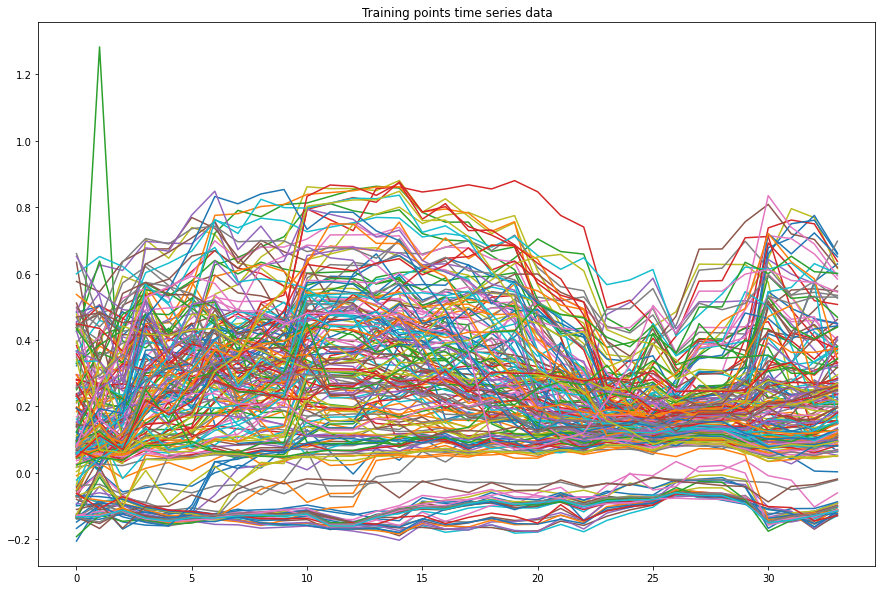

In [43]:
# Plotting out training dataset
x_t = np.transpose(np.squeeze(np.asarray(x)))
print(x_t.shape)
plt.figure(figsize=(15,10))
plt.plot(x_t[:,:200]);
plt.title('Training points time series data');


In [44]:
print('Shape of X',x_t.shape)
print('Shape of label y',y.shape)

Shape of X (34, 2855)
Shape of label y (2855,)


In [45]:
x_t = np.moveaxis(x_t,0,1)
#y=np.expand_dims(y,1)

In [46]:
print(x_t.shape)
print(y.shape)

(2855, 34)
(2855,)


In [47]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder,LabelEncoder

#enc=OneHotEncoder()
#y_new = enc.fit_transform(y).toarray()
#print('One hot encoded shape of data',y_new.shape)

# ...
# # encode class values as integers
# encoder = LabelEncoder()
# encoder.fit(y)
# y_new = encoder.transform(y)
# print('Label Encoded shape of data',y_new.shape)

In [48]:
X_train,X_test,y_train,y_test = train_test_split(x_t,y,test_size=0.3)
print(f"X_train :{X_train.shape}\ny_train:{y_train.shape}\nX_test:{X_test.shape}\ny_test:{y_test.shape}")

X_train :(1998, 34)
y_train:(1998,)
X_test:(857, 34)
y_test:(857,)


In [49]:
X_train=X_train.reshape(-1,x_t.shape[1],1)
X_test= X_test.reshape(-1,x_t.shape[1],1)

print(X_train.shape)
print(X_test.shape)

(1998, 34, 1)
(857, 34, 1)


In [50]:
ip_shape = X_train[1].shape
#n_outputs = y_train.shape[0]
#y_train.shape

In [51]:
ip_shape

(34, 1)

In [52]:
model = Sequential(name = '1D_CNN_Model')

model.add(Conv1D(filters = 64, kernel_size = 3, activation ='relu', input_shape =(ip_shape[0],1), name = 'Layer1'))
model.add(Conv1D(filters = 64, kernel_size = 3, activation ='relu' , name = 'Layer2'))
model.add(Conv1D(filters = 64, kernel_size = 3, activation ='relu' , name = 'Layer3'))

model.add(MaxPooling1D(pool_size = 2, name = 'MaxPooling_Layer1'))
model.add(Dropout(0.4, name = 'Dropout1'))

model.add(Conv1D(filters = 32, kernel_size = 3, activation ='relu', name = 'Layer4'))
model.add(Conv1D(filters = 32, kernel_size = 3, activation ='relu', name = 'Layer5'))
model.add(Conv1D(filters = 32, kernel_size = 3, activation ='relu', name = 'Layer6'))

model.add(MaxPooling1D(pool_size = 2, name = 'MaxPooling_Layer2'))
model.add(Dropout(0.4, name = 'Dropout2'))

model.add(Flatten(name = 'Flatten'))

model.add(Dense(25, activation='relu', name = 'DenseLayer'))

model.add(Dense(1, activation='sigmoid', name = 'OutputLayer'))


#model.summary()

In [53]:
LSTM_model = Sequential(name = 'Toby_LSTM')

LSTM_model.add(LSTM(100,input_shape=(ip_shape[0],1)))
LSTM_model.add(Dropout(0.5))
LSTM_model.add(Dense(100,activation='relu'))
LSTM_model.add(Dense(50,activation='relu'))
LSTM_model.add(Dense(1,activation='sigmoid',name='OutputLayer'))

LSTM_model.summary()

Model: "Toby_LSTM"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 100)               40800     
                                                                 
 dropout (Dropout)           (None, 100)               0         
                                                                 
 dense (Dense)               (None, 100)               10100     
                                                                 
 dense_1 (Dense)             (None, 50)                5050      
                                                                 
 OutputLayer (Dense)         (None, 1)                 51        
                                                                 
Total params: 56,001
Trainable params: 56,001
Non-trainable params: 0
_________________________________________________________________


In [54]:
def dice_coef(y_true, y_pred):
  y_true = tf.cast(y_true, tf.float32)  # -------------------------------------------------- explicit cast
  y_true = K.flatten(y_true)
  y_pred = K.flatten(y_pred)
  intersection = K.sum(y_true * y_pred)
  return 2.0 * intersection / (K.sum(y_true) + K.sum(y_pred) + 1.)

## function for measuring loss value
def dice_coef_loss(y_true, y_pred):
  y_true = tf.cast(y_true, tf.float32)  # -------------------------------------------------- explicit cast
  return 1.0 - dice_coef(y_true, y_pred)

## Merge loss
def bce_dice_loss(y_true, y_pred):
  y_true = tf.cast(y_true, tf.float32)  # -------------------------------------------------- explicit cast
  a = 0.5
  b = 1-a
  loss = a * K.binary_crossentropy(y_true, y_pred) + b * dice_coef_loss(y_true, y_pred)
  return loss

In [55]:

model.compile(loss=bce_dice_loss, optimizer='adam',metrics=['accuracy',tf.keras.metrics.Precision(name='precision'), tf.keras.metrics.Recall(name='recall')])
LSTM_model.compile(loss=bce_dice_loss, optimizer='adam', metrics=['accuracy',tf.keras.metrics.Precision(name='precision'), tf.keras.metrics.Recall(name='recall')])

In [56]:

#model.compile(loss='binary_crossentropy', optimizer='adam',metrics=[tf.keras.metrics.Precision(name='precision'), tf.keras.metrics.Recall(name='recall')])
#LSTM_model.compile(loss=bce_dice_loss, optimizer='adam', metrics=[tf.keras.metrics.Precision(name='precision'), tf.keras.metrics.Recall(name='recall')])

In [57]:
%%time
hist = model.fit(X_train, 
                       y_train, 
                       epochs = 50, 
                       batch_size = 16 , 
                       validation_data = (X_test, y_test))

Epoch 1/50
125/125 [==============================] - 15s 20ms/step - loss: 0.5447 - accuracy: 0.8168 - precision: 0.5068 - recall: 0.4000 - val_loss: 0.4749 - val_accuracy: 0.8005 - val_precision: 0.4623 - val_recall: 0.9060
Epoch 2/50
125/125 [==============================] - 1s 12ms/step - loss: 0.4543 - accuracy: 0.8253 - precision: 0.5203 - recall: 0.7270 - val_loss: 0.4375 - val_accuracy: 0.8576 - val_precision: 0.5692 - val_recall: 0.7450
Epoch 3/50
125/125 [==============================] - 1s 12ms/step - loss: 0.4448 - accuracy: 0.8358 - precision: 0.5422 - recall: 0.7297 - val_loss: 0.4709 - val_accuracy: 0.8576 - val_precision: 0.6063 - val_recall: 0.5168
Epoch 4/50
125/125 [==============================] - 2s 17ms/step - loss: 0.4376 - accuracy: 0.8498 - precision: 0.5742 - recall: 0.7324 - val_loss: 0.4300 - val_accuracy: 0.8553 - val_precision: 0.5581 - val_recall: 0.8054
Epoch 5/50
125/125 [==============================] - 1s 12ms/step - loss: 0.4223 - accuracy: 0.859

In [58]:
%%time
hist2 = LSTM_model.fit(X_train, 
                       y_train, 
                       epochs = 50, 
                       batch_size = 16 , 
                       validation_data = (X_test, y_test))

Epoch 1/50
125/125 [==============================] - 7s 23ms/step - loss: 0.6097 - accuracy: 0.7943 - precision: 0.4072 - recall: 0.2432 - val_loss: 0.4922 - val_accuracy: 0.8215 - val_precision: 0.4919 - val_recall: 0.8188
Epoch 2/50
125/125 [==============================] - 2s 16ms/step - loss: 0.4728 - accuracy: 0.8448 - precision: 0.5676 - recall: 0.6811 - val_loss: 0.4846 - val_accuracy: 0.8553 - val_precision: 0.6050 - val_recall: 0.4832
Epoch 3/50
125/125 [==============================] - 2s 16ms/step - loss: 0.4277 - accuracy: 0.8544 - precision: 0.5857 - recall: 0.7297 - val_loss: 0.4413 - val_accuracy: 0.8320 - val_precision: 0.5100 - val_recall: 0.8591
Epoch 4/50
125/125 [==============================] - 2s 16ms/step - loss: 0.4304 - accuracy: 0.8579 - precision: 0.5900 - recall: 0.7622 - val_loss: 0.4274 - val_accuracy: 0.8693 - val_precision: 0.5969 - val_recall: 0.7651
Epoch 5/50
125/125 [==============================] - 2s 16ms/step - loss: 0.4323 - accuracy: 0.8483

In [59]:
print(hist.history.keys())
print(hist2.history.keys())

dict_keys(['loss', 'accuracy', 'precision', 'recall', 'val_loss', 'val_accuracy', 'val_precision', 'val_recall'])
dict_keys(['loss', 'accuracy', 'precision', 'recall', 'val_loss', 'val_accuracy', 'val_precision', 'val_recall'])


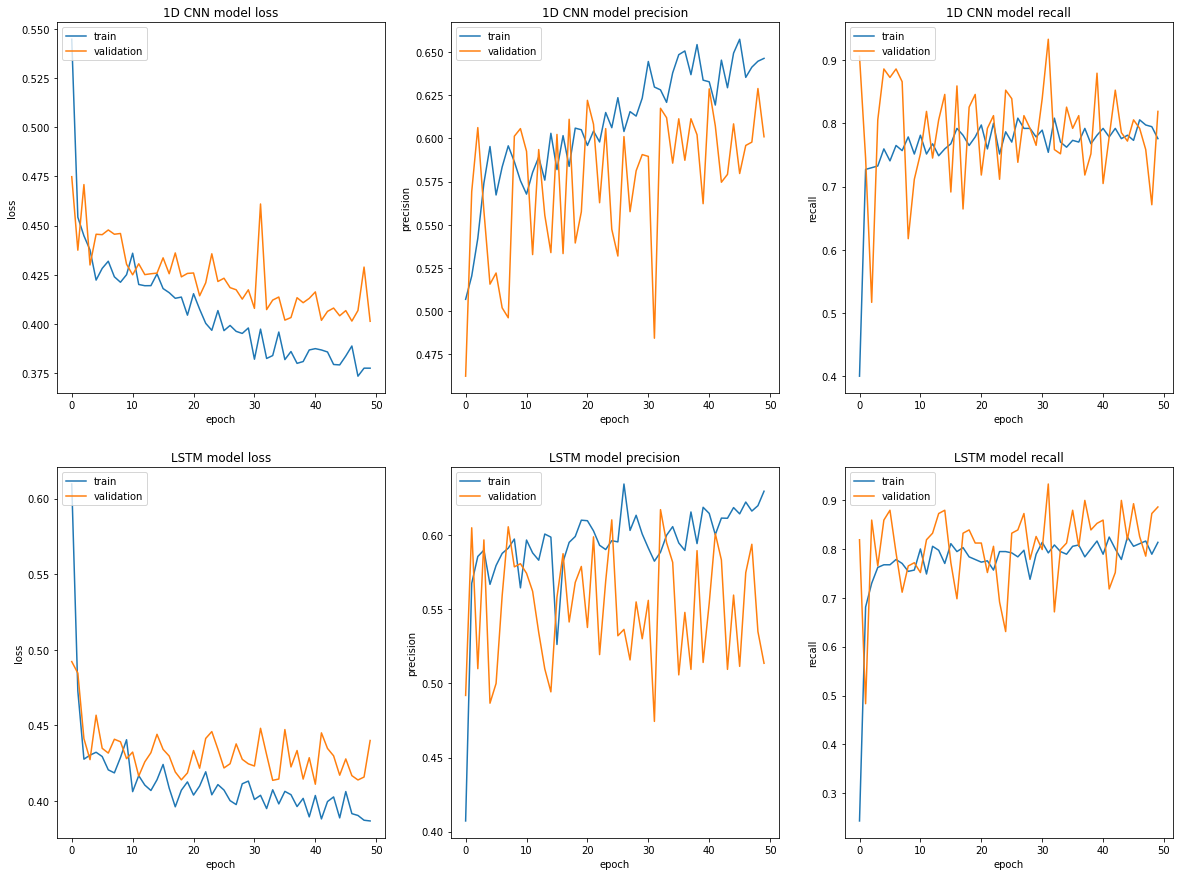

In [60]:
fig,((ax11,ax12,ax13),(ax21,ax22,ax23)) = plt.subplots(2,3,figsize=(20,15))
ax11.plot(hist.history['loss'])
ax11.plot(hist.history['val_loss'])
ax11.title.set_text('1D CNN model loss')
ax11.set_ylabel('loss')
ax11.set_xlabel('epoch')
ax11.legend(['train', 'validation'], loc='upper left')

ax12.plot(hist.history['precision'])
ax12.plot(hist.history['val_precision'])
ax12.set_title('1D CNN model precision')
ax12.set_ylabel('precision')
ax12.set_xlabel('epoch')
ax12.legend(['train', 'validation'], loc='upper left')

ax13.plot(hist.history['recall'])
ax13.plot(hist.history['val_recall'])
ax13.set_title('1D CNN model recall')
ax13.set_ylabel('recall')
ax13.set_xlabel('epoch')
ax13.legend(['train', 'validation'], loc='upper left')

ax21.plot(hist2.history['loss'])
ax21.plot(hist2.history['val_loss'])
ax21.title.set_text('LSTM model loss')
ax21.set_ylabel('loss')
ax21.set_xlabel('epoch')
ax21.legend(['train', 'validation'], loc='upper left')

ax22.plot(hist2.history['precision'])
ax22.plot(hist2.history['val_precision'])
ax22.set_title('LSTM model precision')
ax22.set_ylabel('precision')
ax22.set_xlabel('epoch')
ax22.legend(['train', 'validation'], loc='upper left')

ax23.plot(hist2.history['recall'])
ax23.plot(hist2.history['val_recall'])
ax23.set_title('LSTM model recall')
ax23.set_ylabel('recall')
ax23.set_xlabel('epoch')
ax23.legend(['train', 'validation'], loc='upper left')


In [61]:
loss,accuracy,precision,recall = model.evaluate(X_test,y_test,verbose=0)
print(f"1D CNN precision :{precision*100} & accuracy :{accuracy *100} recall :{recall*100} & loss : {loss}")

loss1,accuracy1,precision1,recall1 = LSTM_model.evaluate(X_test,y_test,verbose=0)
print(f"LSTM precision :{precision1*100} & accuracy : {accuracy1*100} recall :{recall1*100} & Loss :{loss1}")

1D CNN precision :60.098522901535034 & accuracy :87.39789724349976 recall :81.8791925907135 & loss : 0.36748790740966797
LSTM precision :51.36186480522156 & accuracy : 83.43057036399841 recall :88.59060406684875 & Loss :0.4124567210674286


In [35]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

In [ ]:
pred = np.argmax(model.predict(X_test),axis=1)
print(classification_report(pred,np.argmax(y_test,1)));

pred1 = np.argmax(LSTM_model.predict(X_test),axis=1)
print(classification_report(pred1,np.argmax(y_test,1)));

In [74]:
from rasterio.plot import reshape_as_raster,reshape_as_image
#src1=  rasterio.open('/content/drive/MyDrive/MyinGyan_corn/evi_data_cube.tif')
#image = src.read()
print(img.shape)
reshaped_img=reshape_as_image(img)
reshaped_img=reshaped_img.reshape(-1,reshaped_img[2].shape[1])
print(reshaped_img.shape)
reshaped_img = np.nan_to_num(reshaped_img)


(34, 1960, 2335)
(4576600, 34)


(4576600,)
Reshaped Image shape :(1960, 2335)


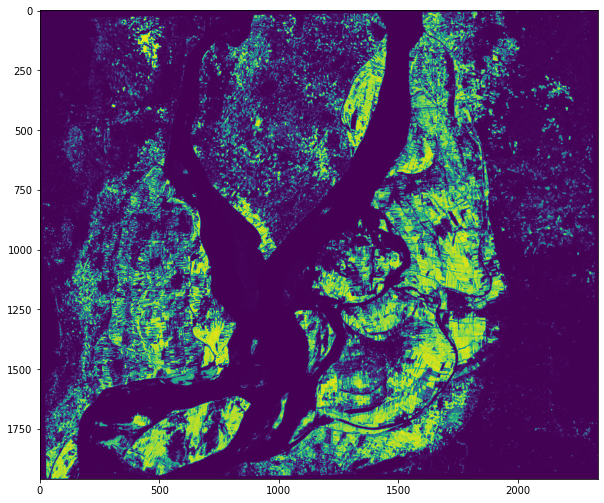

In [86]:
pred_1D = np.squeeze(model.predict(reshaped_img))
print(pred_1D.shape)
pred_1D = pred_1D.reshape(img.shape[1],img.shape[2])
print(f'Reshaped Image shape :{pred_1D.shape}')
plt.figure(figsize=(10,10))
plt.imshow(pred_1D)

(4576600,)
Reshaped Image shape :(1960, 2335)


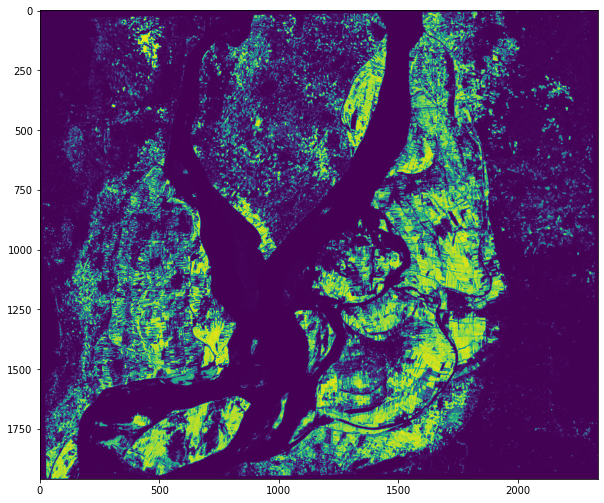

In [87]:
pred_LSTM = np.squeeze(model.predict(reshaped_img))
print(pred_LSTM.shape)
pred_LSTM = pred_LSTM.reshape(img.shape[1],img.shape[2])
print(f'Reshaped Image shape :{pred_LSTM.shape}')
plt.figure(figsize=(10,10))
plt.imshow(pred_LSTM)

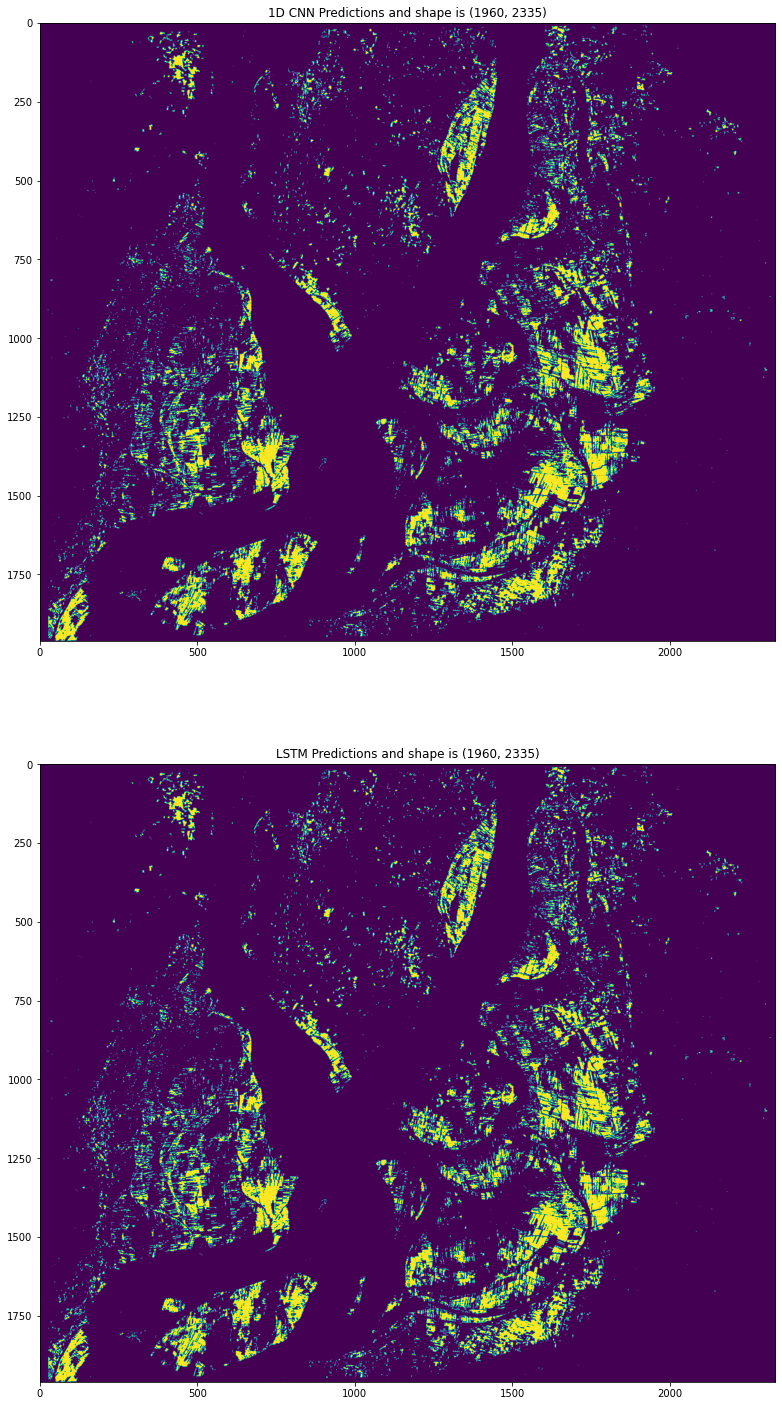

In [97]:
fig,(ax1,ax2)=plt.subplots(2,1,figsize=(25,25))
ax1.imshow(pred_1D>=0.83)
ax1.set_title(f'1D CNN Predictions and shape is {pred_1D.shape}');
ax2.imshow(pred_LSTM>=0.83)
ax2.set_title(f'LSTM Predictions and shape is {pred_LSTM.shape}');


In [94]:
model.save('/content/1D_CNN&LSM trained Weights/1D_CNN/1D_cnn_weights.h5')
LSTM_model.save('/content/1D_CNN&LSM trained Weights/LSTM/LSTM_model_weights.h5')

In [100]:
import tifffile as tfl
tfl.imsave('/content/Predicted Image/1D_cnn_pred.tif',pred_1D>=0.83)
tfl.imsave('/content/Predicted Image/LSTM_pred.tif',pred_LSTM>=0.83)

In [103]:
import geo_process

In [104]:
from geo_process import geo_ref

In [112]:
ref_img = '/content/drive/MyDrive/MyinGyan_corn/evi_data_cube.tif'
#target_img = '/content/Predicted Image/1D_cnn_pred.tif'
target_img = '/content/Predicted Image/LSTM_pred.tif'

In [113]:
#geo_ref(ref_img,target_img,'/content/GeoRef_pred/geo_referenced_1D_CNN_pred.tif')
geo_ref(ref_img,target_img,'/content/GeoRef_pred/geo_referenced_LSTM_pred.tif')

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

In [114]:
!zip -r '/content/DL_1DCNN_LSTM_weights.zip' '/content/1D_CNN&LSM trained Weights'
!zip -r '/content/Predicted Images.zip' '/content/Predicted Image'
!zip -r '/content/GeoRef_pred.zip' '/content/GeoRef_pred'

updating: content/1D_CNN&LSM trained Weights/ (stored 0%)
updating: content/1D_CNN&LSM trained Weights/.ipynb_checkpoints/ (stored 0%)
updating: content/1D_CNN&LSM trained Weights/LSTM/ (stored 0%)
updating: content/1D_CNN&LSM trained Weights/LSTM/LSTM_model_weights.h5 (deflated 12%)
updating: content/1D_CNN&LSM trained Weights/1D_CNN/ (stored 0%)
updating: content/1D_CNN&LSM trained Weights/1D_CNN/.ipynb_checkpoints/ (stored 0%)
updating: content/1D_CNN&LSM trained Weights/1D_CNN/1D_cnn_weights.h5 (deflated 26%)
updating: content/Predicted Image/ (stored 0%)
updating: content/Predicted Image/LSTM_pred.tif (deflated 80%)
updating: content/Predicted Image/1D_cnn_pred.tif (deflated 80%)
  adding: content/GeoRef_pred/ (stored 0%)
  adding: content/GeoRef_pred/geo_referenced_1D_CNN_pred.tif (deflated 97%)
  adding: content/GeoRef_pred/.ipynb_checkpoints/ (stored 0%)
  adding: content/GeoRef_pred/geo_referenced_LSTM_pred.tif (deflated 97%)


In [79]:
# from PIL import Image
# label_img = np.asarray(Image.open('/content/drive/MyDrive/MyinGyan_corn/masked corn20.tif'))
# label_img.shape

(1959, 2335)

In [92]:
# from sklearn.metrics import classification_report
# cr_1d = classification_report(pred_1D[1:,:].flatten(),label_img.flatten())
# #cr_lstm = classification_report(pred1,label_img.flatten())


In [ ]:
# print("Classification report of 1D CNN model\n",cr_1d )
# print("=======================================================")
# print("Classification report of LSTM model\n",cr_lstm)

In [ ]:
# fig,(ax1,ax2,ax3)=plt.subplots(3,1,figsize=(25,25))
# ax1.imshow(pred_final==1)
# ax1.set_title(f'1D CNN Predictions and shape is {pred_final.shape}');
# ax2.imshow(pred1_final==1)
# ax2.set_title(f'LSTM Predictions and shape is {pred1_final.shape}');
# ax3.imshow(label_img)
# ax3.set_title(f'Label and shape is {label_img.shape}');

In [ ]:
# fig,(ax1,ax2,ax3) =plt.subplots(1,3,figsize=(15,10))
# ax1.hist(pred)
# ax1.set_title('1D CNN Predictions')
# ax2.hist(pred1)
# ax2.set_title('LSTM Predictions')
# ax3.hist(label_img)
# ax3.set_title('Label image')